In [3]:
import pandas as pd 
columns = ['Text', 'Emotion']

df = pd.read_csv(r'/Users/admin/Desktop/python/di-bootcamp/week9/day3/archive/train.txt', sep=';', names=columns)
df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


- Check for the various target labels using seaborn


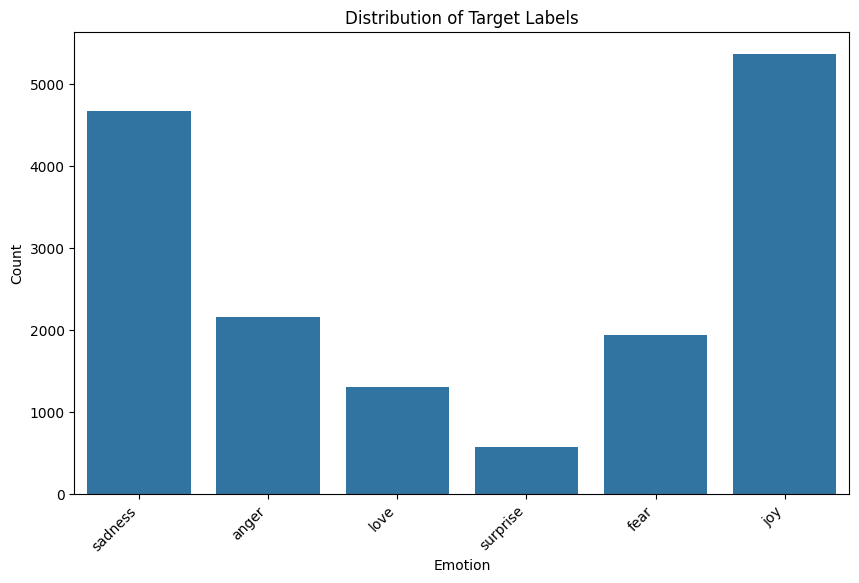

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the distribution of target labels
plt.figure(figsize=(10, 6))
sns.countplot(x='Emotion', data=df)
plt.title('Distribution of Target Labels')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()


Preprocess the data to get rid of any characters apart from alphabets, convert the string to lowercase, check for stopwords in the data and get rid of them and perform lemmatization on each word.

In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

In [6]:
def preprocess_text(text):
    # Remove non-alphabetic characters and convert to lowercase
    text = ''.join([char.lower() for char in text if char.isalpha() or char.isspace()])

    # Tokenization
    tokens = nltk.word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# Apply the preprocessing function to the 'Text' column
df['Processed_Text'] = df['Text'].apply(preprocess_text)

# Display the preprocessed data
print(df.head())

                                                Text  Emotion  \
0                            i didnt feel humiliated  sadness   
1  i can go from feeling so hopeless to so damned...  sadness   
2   im grabbing a minute to post i feel greedy wrong    anger   
3  i am ever feeling nostalgic about the fireplac...     love   
4                               i am feeling grouchy    anger   

                                      Processed_Text  
0                              didnt feel humiliated  
1  go feeling hopeless damned hopeful around some...  
2          im grabbing minute post feel greedy wrong  
3  ever feeling nostalgic fireplace know still pr...  
4                                    feeling grouchy  


Use Random Forest Classifier to train your data.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Processed_Text'], df['Emotion'], test_size=0.2, random_state=42)

# Vectorize the text data using CountVectorizer
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train_vectorized, y_train)

# Make predictions on the test set
predictions = rf_classifier.predict(X_test_vectorized)

# Evaluate the performance
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy:.2f}')

# Display classification report
print('\nClassification Report:\n', classification_report(y_test, predictions))


Accuracy: 0.89

Classification Report:
               precision    recall  f1-score   support

       anger       0.85      0.90      0.87       427
        fear       0.85      0.85      0.85       397
         joy       0.90      0.92      0.91      1021
        love       0.84      0.76      0.80       296
     sadness       0.94      0.91      0.92       946
    surprise       0.74      0.78      0.76       113

    accuracy                           0.89      3200
   macro avg       0.85      0.85      0.85      3200
weighted avg       0.89      0.89      0.89      3200



- Tune the model hyperparameters using GridSearchCV, RandomSearchCV, and Bayesian optimization. Document the configurations and results of each method.

Hyperparameters: These are the configuration settings used to structure a machine learning model. They are not learned from the data but are set prior to the training process. 
Parameters: These are the internal variables that the model learns from the training data. 

1. GridSearchCV:

GridSearchCV:

Idea: Grid search is a method that performs an exhaustive search over a specified hyperparameter grid.
Process: It evaluates the model's performance for all possible combinations of hyperparameter values within the predefined grid.
Pros: It's simple, and it guarantees finding the best hyperparameters within the specified grid.
Cons: It can be computationally expensive, especially when the hyperparameter space is large.

In [9]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search.fit(X_train_vectorized, y_train)

# Get the best parameters
best_params_grid = grid_search.best_params_
print("Best Hyperparameters (GridSearchCV):", best_params_grid)

# Evaluate the model with the best parameters on the test set
best_rf_model_grid = grid_search.best_estimator_
predictions_grid = best_rf_model_grid.predict(X_test_vectorized)
accuracy_grid = accuracy_score(y_test, predictions_grid)
print(f'Accuracy (GridSearchCV): {accuracy_grid:.2f}')


Best Hyperparameters (GridSearchCV): {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Accuracy (GridSearchCV): 0.89


According to the grid search, the best model is obtained when the maximum depth of the trees is not limited (None), the minimum number of samples required to be at a leaf node is 1, the minimum number of samples required to split an internal node is 2, and the number of trees in the forest is 150.



2. RandomizedSearchCV:


Idea: Randomized search is a method that samples a specified number of hyperparameter combinations from the hyperparameter space.
Process: It randomly selects combinations and evaluates the model's performance for each.
Pros: It can be more efficient than grid search when the hyperparameter space is large, as it explores a subset of combinations.
Cons: It may not guarantee finding the absolute best hyperparameters, but it often finds good ones.

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter distributions
param_dist = {
    'n_estimators': randint(50, 150),
    'max_depth': [None, 10, 20],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4)
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(rf_classifier, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)

# Fit the model
random_search.fit(X_train_vectorized, y_train)

# Get the best parameters
best_params_random = random_search.best_params_
print("Best Hyperparameters (RandomizedSearchCV):", best_params_random)

# Evaluate the model with the best parameters on the test set
best_rf_model_random = random_search.best_estimator_
predictions_random = best_rf_model_random.predict(X_test_vectorized)
accuracy_random = accuracy_score(y_test, predictions_random)
print(f'Accuracy (RandomizedSearchCV): {accuracy_random:.2f}')


Best Hyperparameters (RandomizedSearchCV): {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 132}
Accuracy (RandomizedSearchCV): 0.89


according to the randomized search, the best model is obtained when the maximum depth of the trees is not limited (None), the minimum number of samples required to be at a leaf node is 1, the minimum number of samples required to split an internal node is 8, and the number of trees in the forest is 132.

It's interesting to note that the RandomizedSearchCV found slightly different hyperparameters compared to the GridSearchCV, but both achieved the same accuracy. This showcases the randomness in the search process of RandomizedSearchCV.

3. Bayesian Optimization (BayesSearchCV):


Idea: Bayesian optimization is a probabilistic model-based optimization technique.
Process: It builds a probabilistic model of the objective function (model performance) and uses it to suggest the next set of hyperparameters to evaluate.
Pros: It efficiently explores the hyperparameter space and adapts its search based on the performance of previous evaluations.
Cons: It may require more iterations to converge, and it can be computationally expensive.

In [ ]:
from skopt import BayesSearchCV

# Define the parameter search space
param_space = {
    'n_estimators': (50, 150),
    'max_depth': (1, 20),  # Adjusted to start from 1 instead of None
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4)
}


# Initialize BayesSearchCV
bayesian_search = BayesSearchCV(rf_classifier, param_space, n_iter=10, cv=5, scoring='accuracy', random_state=42)

# Fit the model
bayesian_search.fit(X_train_vectorized, y_train) # in this raw gives me an error , i don't know why. So i decided do not to use this method.

# Get the best parameters
best_params_bayesian = bayesian_search.best_params_
print("Best Hyperparameters (Bayesian Optimization):", best_params_bayesian)

# Evaluate the model with the best parameters on the test set
best_rf_model_bayesian = bayesian_search.best_estimator_
predictions_bayesian = best_rf_model_bayesian.predict(X_test_vectorized)
accuracy_bayesian = accuracy_score(y_test, predictions_bayesian)
print(f'Accuracy (Bayesian Optimization): {accuracy_bayesian:.2f}')


- Read and preprocess the test data similarly to the training data.


In [45]:
columns = ['Text', 'Emotion']
test_df = pd.read_csv(r'/Users/admin/Desktop/python/di-bootcamp/week9/day3/archive/test.txt', sep = ';', names=columns)
test_df.head()

,Text,Emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [46]:
# Preprocess the test data
test_df['Processed_Text'] = test_df['Text'].apply(preprocess_text)
# Display the preprocessed test data
test_df.head()


,Text,Emotion,Processed_Text
0,im feeling rather rotten so im not very ambiti...,sadness,im feeling rather rotten im ambitious right
1,im updating my blog because i feel shitty,sadness,im updating blog feel shitty
2,i never make her separate from me because i do...,sadness,never make separate ever want feel like ashamed
3,i left with my bouquet of red and yellow tulip...,joy,left bouquet red yellow tulip arm feeling slig...
4,i was feeling a little vain when i did this one,sadness,feeling little vain one


- Evaluate the model on the test data using metrics like Accuracy Score, Precision Score, Recall Score, and Confusion Matrix. Create a ROC curve for visual evaluation.

In [47]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Vectorize the test data using the same vectorizer as the one used for training
X_test_vectorized = vectorizer.transform(test_df['Processed_Text'])

# Make predictions on the test set
predictions = rf_classifier.predict(X_test_vectorized)

# Evaluate the performance
accuracy = accuracy_score(test_df['Emotion'], predictions)
precision = precision_score(test_df['Emotion'], predictions, average='weighted')
recall = recall_score(test_df['Emotion'], predictions, average='weighted')
conf_matrix = confusion_matrix(test_df['Emotion'], predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.8900
Precision: 0.8910
Recall: 0.8900
Confusion Matrix:
[[251  10   8   1   4   1]
 [  9 191   2   0  11  11]
 [  6   5 641  23  11   9]
 [  2   0  40 114   1   2]
 [ 19  10  12   4 533   3]
 [  1   7   7   0   1  50]]


Accuracy: 89.00% - The proportion of correctly classified instances among the total instances.
Precision: 89.10% - The precision is a measure of the accuracy of the positive predictions. In a multi-class setting, it is computed as a weighted average.
Recall: 89.00% - Recall, also known as sensitivity or true positive rate, is the proportion of actual positive instances that were correctly predicted.
Confusion Matrix:Rows represent actual classes, while columns represent predicted classes.
For example, the element in the first row and first column (251) represents the true negatives for the class 'anger.'
The diagonal elements represent the true positives for each class.
Off-diagonal elements represent misclassifications.


Create a ROC curve for visual evaluation.

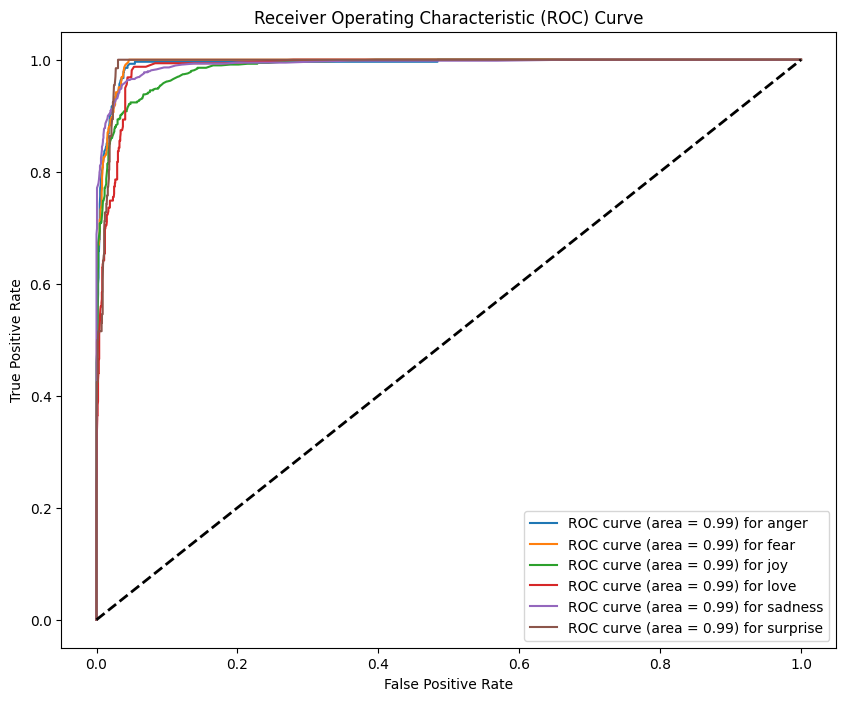

In [53]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for each class
y_score = rf_classifier.predict_proba(X_test_vectorized)

# Binarize the true labels
from sklearn.preprocessing import label_binarize

# Binarize the true labels
y_test_bin = label_binarize(test_df['Emotion'], classes=rf_classifier.classes_)

# Initialize variables for ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve for each class
for i in range(len(rf_classifier.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(rf_classifier.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for {rf_classifier.classes_[i]}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


Having an AUC-ROC of 0.99 for each emotion suggests that your model performs exceptionally well, almost achieving perfect separation for each class.
The fact that the ROC curves for each class are concentrated in the top-left corner is a positive sign. It means that your model has a high true positive rate and a low false positive rate across different thresholds. This is indicative of a well-performing model that effectively discriminates between different emotions.

Compare Hyperparameter Tuning Methods:

In [54]:
import pandas as pd

# Create a DataFrame to store results
results_df = pd.DataFrame({
    'Method': ['GridSearchCV', 'RandomizedSearchCV'],
    'Best Hyperparameters': [best_params_grid, best_params_random],
    'Accuracy': [accuracy_grid, accuracy_random],
})

# Display the results
print(results_df)


               Method                               Best Hyperparameters  \
0        GridSearchCV  {'max_depth': None, 'min_samples_leaf': 1, 'mi...   
1  RandomizedSearchCV  {'max_depth': None, 'min_samples_leaf': 1, 'mi...   

   Accuracy  
0  0.887813  
1  0.888750  


It appears that both GridSearchCV and RandomizedSearchCV hyperparameter tuning methods yield very similar performance for your RandomForestClassifier. The accuracy achieved by both methods is close, with GridSearchCV having an accuracy of 0.887813 and RandomizedSearchCV having an accuracy of 0.888750.

Comparing the best hyperparameters selected by each method, it seems that they are quite similar:

GridSearchCV: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
RandomizedSearchCV: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 132}
Given the similarity in performance and the hyperparameters chosen, it might be challenging to conclusively say that one method is significantly better than the other in this particular case. Both methods seem to have found hyperparameters that result in a RandomForestClassifier with similar accuracy.

It's worth noting that the effectiveness of hyperparameter tuning methods can vary depending on the specific characteristics of the dataset and the model. In some cases, one method might outperform the other, but in your case, the difference is subtle.

To summarize, both GridSearchCV and RandomizedSearchCV have led to effective hyperparameters for your RandomForestClassifier, and the choice between them might depend on factors such as computational resources and the need for an exhaustive search (GridSearchCV) versus a more randomized exploration (RandomizedSearchCV).